In [ ]:
# Installing required packages
!pip install patchify

In [7]:
!pip3 install keras==2.3.1

     -------------------------------------- 377.8/377.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires keras<2.11,>=2.10.0, but you have keras 2.3.1 which is incompatible.
tensorflow-intel 2.10.0 requires keras<2.11,>=2.10.0, but you have keras 2.3.1 which is incompatible.


In [5]:
!pip3 install -U segmentation-models

     ---------------------------------------- 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [8]:
# Importing libraries
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [9]:
# Scaling the data using scalar minmax
scaler = MinMaxScaler()

In [22]:
# Setting the root directory
root_directory = 'C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/'

# Setting patch size
patch_size = 256

In [25]:
for path, subdirs, files in os.walk(root_directory):
    print(path, subdirs, files)

C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/ ['Tile 1', 'Tile 2', 'Tile 3', 'Tile 4', 'Tile 5', 'Tile 6', 'Tile 7', 'Tile 8'] ['classes.json']
C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1 ['images', 'masks'] []
C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images [] ['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks [] ['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 2 ['images', 'masks'

In [30]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: C:/U

In [31]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_001.png
Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_002.png
Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_003.png
Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_004.png
Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_005.png
Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_006.png
Now patchifying mask: C:/Users/aky/Documents/Programs/computer-vision/data/Semantic segmentation dataset/Tile 1\masks/image_part_007.png
Now patchifying mask: C:/Users/aky/Docume

In [32]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

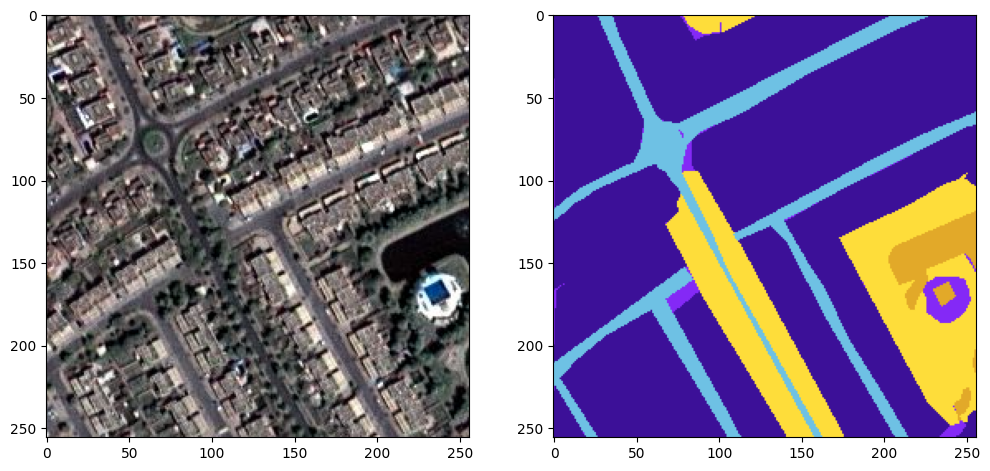

In [39]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

RGB to HEX: (Hexadecimel --> base 16)</br>
This number divided by sixteen (integer division; ignoring any remainder) gives </br>
the first hexadecimal digit (between 0 and F, where the letters A to F represent </br>
the numbers 10 to 15). The remainder gives the second hexadecimal digit. </br>
0-9 --> 0-9</br>
10-15 --> A-F</br>

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098</br>
3C = 3*16 + 12 = 60</br>
10 = 1*16 + 0 = 16</br>
98 = 9*16 + 8 = 152</br>


In [35]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)

60


In [36]:
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [ ]:
label = single_patch_mask

In [37]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [38]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [40]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


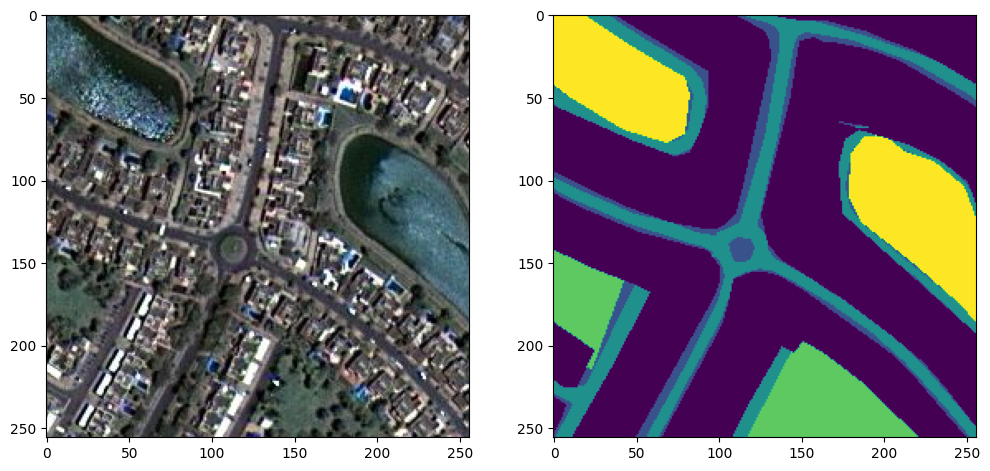

In [41]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [42]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

# Parameters for model
Segmentation models losses can be combined together by '+' and scaled by integer or float factor </br>
set class weights for dice_loss</br>
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), np.ravel(labels,order='C'))</br>
print(weights)

In [44]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [45]:
# dice loss are used for segmentation
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
# focal loss for multi-classification
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [46]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [49]:
from simple_multi_unet_model import multi_unet_model, jacard_coef

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [50]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [51]:
model.input_shape

(None, 256, 256, 3)

In [52]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/66 [================>.............] - ETA: 7:01 - loss: 1.0028 - accuracy: 0.5171 - jacard_coef: 0.2288Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\aky\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aky\AppData\Local\Temp\ipykernel_9664\3077684640.py", line 1, in <module>
    history1 = model.fit(X_train, y_train,
  File "c:\Users\aky\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
  File "c:\Users\aky\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1564, in fit
  File "c:\Users\aky\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\aky\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "c:\Users\aky

In [ ]:
#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)            
#With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)
#With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)
##With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)
#Using categorical crossentropy as loss: 0.71

##With calculated weights in Dice loss.    
#With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)

In [ ]:
##Standardscaler 
#Using categorical crossentropy as loss: 0.677

#model.save('models/satellite_standard_unet_100epochs_7May2021.hdf5')

In [ ]:
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [ ]:
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [ ]:
# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
print(model_resnet_backbone.summary())

In [ ]:
print(model_resnet_backbone.summary())

In [ ]:
#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is:               
#With dice + 5 focal, after 100 epochs val jacard is: 0.73 (reached 0.71 in 40 epochs. So faster training but not better result. )
##With dice + 1 focal, after 100 epochs val jacard is:   
    ##Using categorical crossentropy as loss: 0.755 (100 epochs)
#With calc. weights supplied to model.fit: 
 
#Standard scaler
#Using categorical crossentropy as loss: 0.74

In [ ]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

In [ ]:
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("models/satellite_standard_unet_100epochs.hdf5",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [ ]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

In [ ]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]